# Error vs Load Latitude

## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyslfp import FingerPrint, IceModel, plot
from joblib import Parallel, delayed
import pyshtools as pysh
import numpy as np

from Part_III_Project import sea_surface_height_change, create_ice_band

## Variable setting

In [65]:
lmax = 512

resolution = 50  # number of points from -90 to 90 degrees
load_radius = [1, 5, 10]  # degrees
load_thickness_change = -100  # meters

satellite_range = np.round(np.linspace(1, 90, resolution), 2)
latitude = np.round(np.linspace(-90, 90, resolution), 2)

## Test

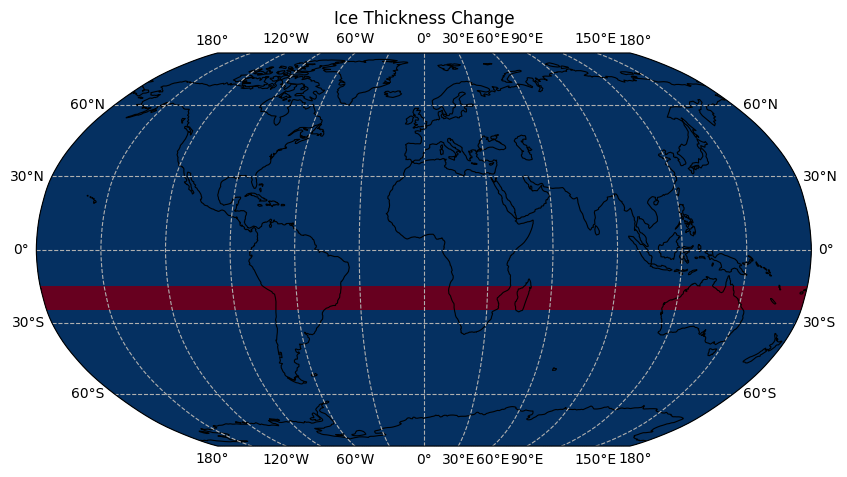

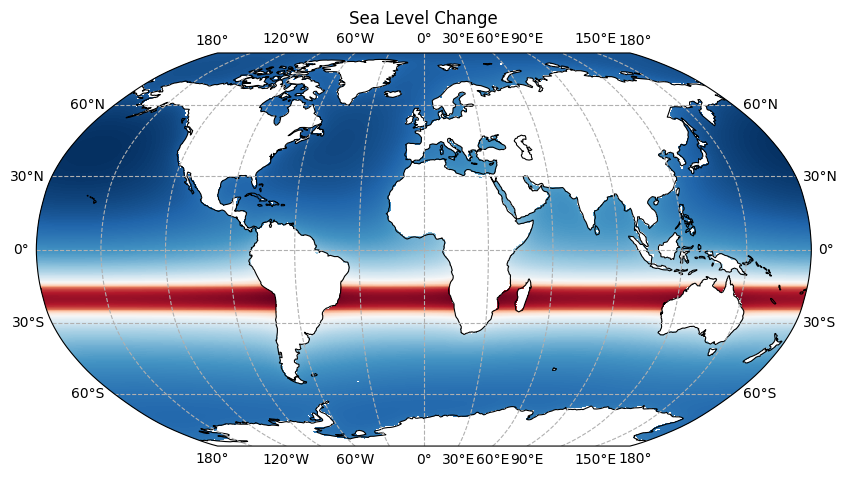

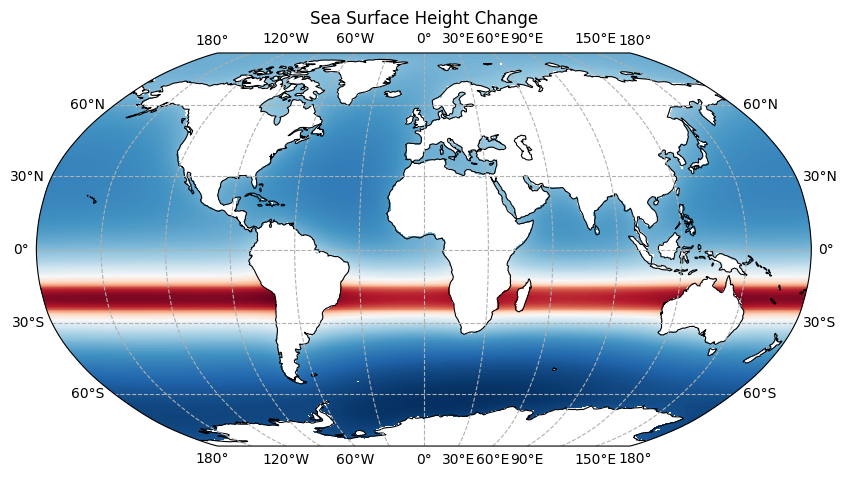

In [90]:
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng()

ice_thickness_change = create_ice_band(
    lat_center=-20,
    lat_width=5,
    ice_thickness=load_thickness_change,
    lmax=lmax,
)

(
    sea_level_change,
    displacement,
    gravity_potential_change,
    angular_velocity_change,
) = fp(direct_load=ice_thickness_change)

sea_surface_height_change_result = sea_surface_height_change(
    fp, sea_level_change, displacement, angular_velocity_change
)

# Create individual plots
fig1, ax1, im1 = plot(ice_thickness_change, coasts=True)
ax1.set_title("Ice Thickness Change")
plt.show()

fig2, ax2, im2 = plot(sea_level_change * fp.ocean_projection(), coasts=True)
ax2.set_title("Sea Level Change")
plt.show()

fig3, ax3, im3 = plot(
    sea_surface_height_change_result * fp.ocean_projection(), coasts=True
)
ax3.set_title("Sea Surface Height Change")
plt.show()

## Error calculation

### Non-parallel version

In [5]:
for load_rad in load_radius:  # Added outer loop for load_radius
    for load_lat in latitude:
        ice_thickness_change = create_ice_band(
            lat_center=load_lat,
            lat_width=load_rad,  # Changed from load_radius to load_rad
            ice_thickness=load_thickness_change,
            lmax=lmax,
        )

        (
            sea_level_change,
            displacement,
            gravity_potential_change,
            angular_velocity_change,
        ) = fp(direct_load=ice_thickness_change)

        sea_surface_height_change_result = sea_surface_height_change(
            fp, sea_level_change, displacement, angular_velocity_change
        )

        mean_sea_level_change = fp.mean_sea_level_change(ice_thickness_change)

        for satellite_lat in satellite_range:
            altimetry_projection = fp.altimetry_projection(
                latitude_min=-satellite_lat, latitude_max=satellite_lat, value=0
            )

            altimetry_projection_integral = fp.integrate(altimetry_projection)
            altimetry_weighting_function = (
                altimetry_projection / altimetry_projection_integral
            )

            mean_sea_level_change_estimate = fp.integrate(
                altimetry_weighting_function * sea_surface_height_change_result
            )

            # Calculate relative error
            if np.abs(mean_sea_level_change) > 1e-10:
                error = (
                    100
                    * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
                    / np.abs(mean_sea_level_change)
                )
            else:
                error = np.nan  # or 0, depending on how you want to handle this case

            results.append(
                {
                    "load_radius": load_rad,  # Added load_radius to results
                    "satellite_range": satellite_lat,
                    "latitude": load_lat,
                    "error": error,
                }
            )

error_output = pd.DataFrame(results)

### Parallel version

It parallelizes over load latitudes and load range, but not over satellite latitudes.

In [66]:
def process_load_latitude_radius(
    load_lat, load_rad, satellite_range, load_thickness_change, lmax
):
    """Process a single load latitude and radius combination with all satellite ranges"""
    # Create a new FingerPrint instance for this process
    fp = FingerPrint(lmax=lmax)
    fp.set_state_from_ice_ng()

    ice_thickness_change = create_ice_band(
        lat_center=load_lat,
        lat_width=load_rad,  # Changed from load_radius to load_rad
        ice_thickness=load_thickness_change,
        lmax=lmax,
    )

    (
        sea_level_change,
        displacement,
        gravity_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=ice_thickness_change)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )

    mean_sea_level_change = fp.mean_sea_level_change(ice_thickness_change)

    # Store results for this load_lat and load_rad combination
    local_results = []

    for satellite_lat in satellite_range:
        altimetry_projection = fp.altimetry_projection(
            latitude_min=-satellite_lat, latitude_max=satellite_lat, value=0
        )

        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        # Calculate relative error
        if np.abs(mean_sea_level_change) > 1e-10:
            error = (
                100
                * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
                / np.abs(mean_sea_level_change)
            )
        else:
            error = np.nan

        local_results.append(
            {
                "load_radius": load_rad,  # Added load_radius to results
                "satellite_range": satellite_lat,
                "latitude": load_lat,
                "error": error,
            }
        )

    return local_results


# Parallel execution over both latitude and load_radius
results_nested = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_load_latitude_radius)(
        load_lat, load_rad, satellite_range, load_thickness_change, lmax
    )
    for load_rad in load_radius  # Added outer loop for load_radius
    for load_lat in latitude
)

# Flatten the nested results
results = [item for sublist in results_nested for item in sublist]

error_output = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:  2.6min remaining:    7.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


In [67]:
print(error_output)
# export to csv
error_output.to_csv("load_lat_error_output.csv", index=False)

      load_radius  satellite_range  latitude     error
0               1             1.00     -90.0  0.335520
1               1             2.82     -90.0  0.337842
2               1             4.63     -90.0  0.328762
3               1             6.45     -90.0  0.320175
4               1             8.27     -90.0  0.315465
...           ...              ...       ...       ...
7495           10            82.73      90.0  5.066750
7496           10            84.55      90.0  5.763721
7497           10            86.37      90.0  6.375518
7498           10            88.18      90.0  6.721793
7499           10            90.00      90.0  6.847047

[7500 rows x 4 columns]


## Plotting results

Plotting as a heatmap of error vs load latitude and satellite coverage

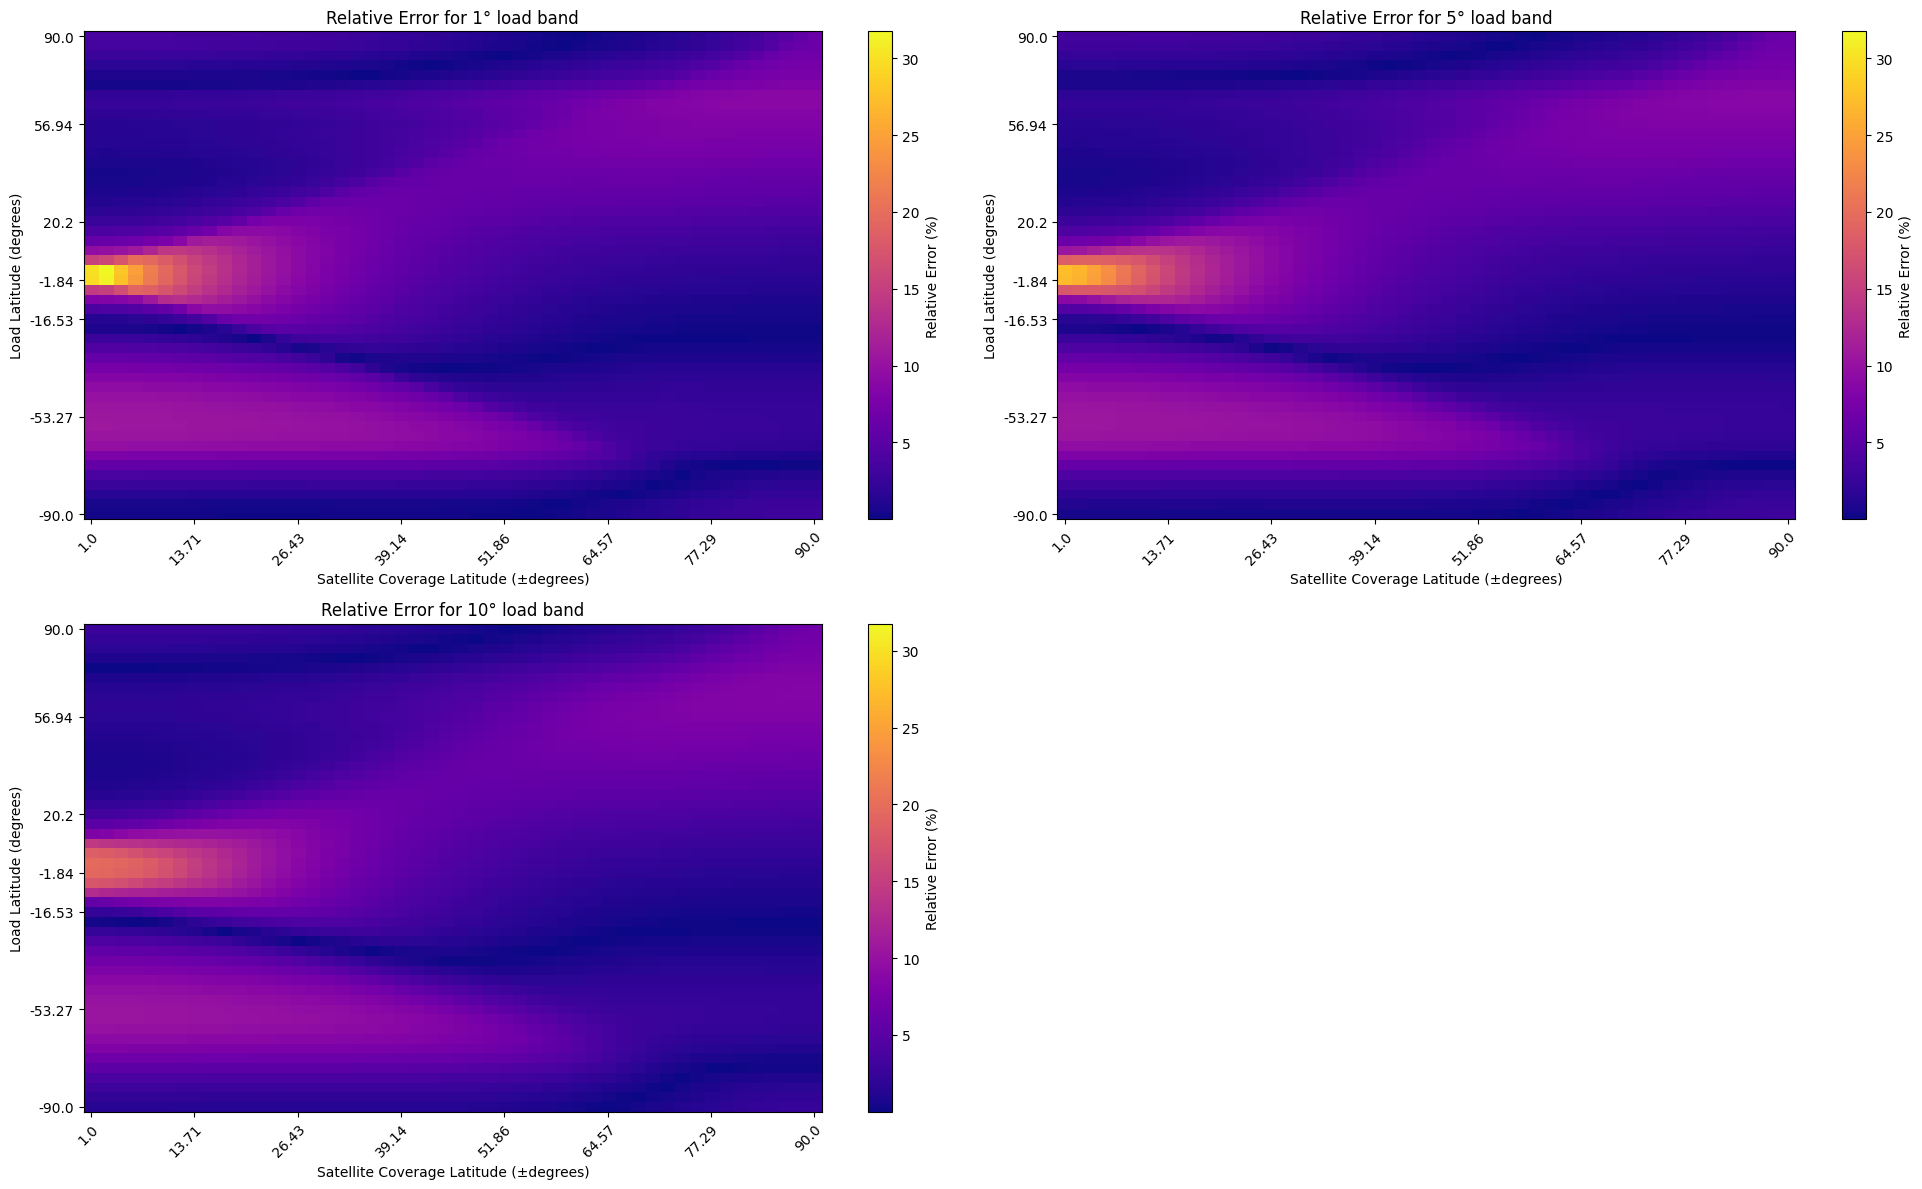

In [71]:
# Get unique load radius values
unique_load_radii = error_output["load_radius"].unique()
n_subplots = len(unique_load_radii)

# Calculate subplot layout (rows x cols)
n_cols = min(2, n_subplots)  # Max 3 columns
n_rows = int(np.ceil(n_subplots / n_cols))

# First pass: determine global vmin and vmax across all load radii
vmin = float("inf")
vmax = float("-inf")
for load_rad in unique_load_radii:
    data_subset = error_output[error_output["load_radius"] == load_rad]
    pivot_table = data_subset.pivot(
        index="latitude", columns="satellite_range", values="error"
    )
    vmin = min(vmin, pivot_table.min().min())
    vmax = max(vmax, pivot_table.max().max())

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 6 * n_rows))

# Flatten axes array for easier iteration
if n_subplots == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

# Create a plot for each load radius
for idx, load_rad in enumerate(sorted(unique_load_radii)):
    ax = axes[idx]

    # Filter data for this load radius
    data_subset = error_output[error_output["load_radius"] == load_rad]

    pivot_table = data_subset.pivot(
        index="latitude", columns="satellite_range", values="error"
    )

    im = ax.imshow(
        pivot_table,
        aspect="auto",
        origin="lower",
        cmap="plasma",
        vmin=vmin,  # Set consistent color scale
        vmax=vmax,  # Set consistent color scale
    )

    plt.colorbar(im, ax=ax, label="Relative Error (%)")
    ax.set_xlabel("Satellite Coverage Latitude (±degrees)")
    ax.set_ylabel("Load Latitude (degrees)")
    ax.set_title(f"Relative Error for {load_rad}° load band")

    # Show all ticks and label them with the respective list entries
    max_ticks = 7

    # X-axis ticks (satellite range)
    if len(satellite_range) <= max_ticks + 1:
        x_tick_indices = list(range(len(satellite_range)))
    else:
        step = len(satellite_range) // max_ticks
        x_tick_indices = list(range(0, len(satellite_range), step))
        if x_tick_indices[-1] != len(satellite_range) - 1:
            x_tick_indices.append(len(satellite_range) - 1)

    # Y-axis ticks (latitude)
    if len(latitude) <= max_ticks:
        y_tick_indices = list(range(len(latitude)))
    else:
        middle_idx = np.argmin(np.abs(latitude))
        step = len(latitude) // (max_ticks - 2)
        y_tick_indices = list(range(0, len(latitude), step))
        if middle_idx not in y_tick_indices:
            y_tick_indices.append(middle_idx)
        if y_tick_indices[-1] != len(latitude) - 1:
            y_tick_indices.append(len(latitude) - 1)
        y_tick_indices = sorted(set(y_tick_indices))

    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels(
        [satellite_range[i] for i in x_tick_indices],
        rotation=45,
        ha="right",
        rotation_mode="anchor",
    )
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([latitude[i] for i in y_tick_indices])

# Hide any unused subplots
for idx in range(n_subplots, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

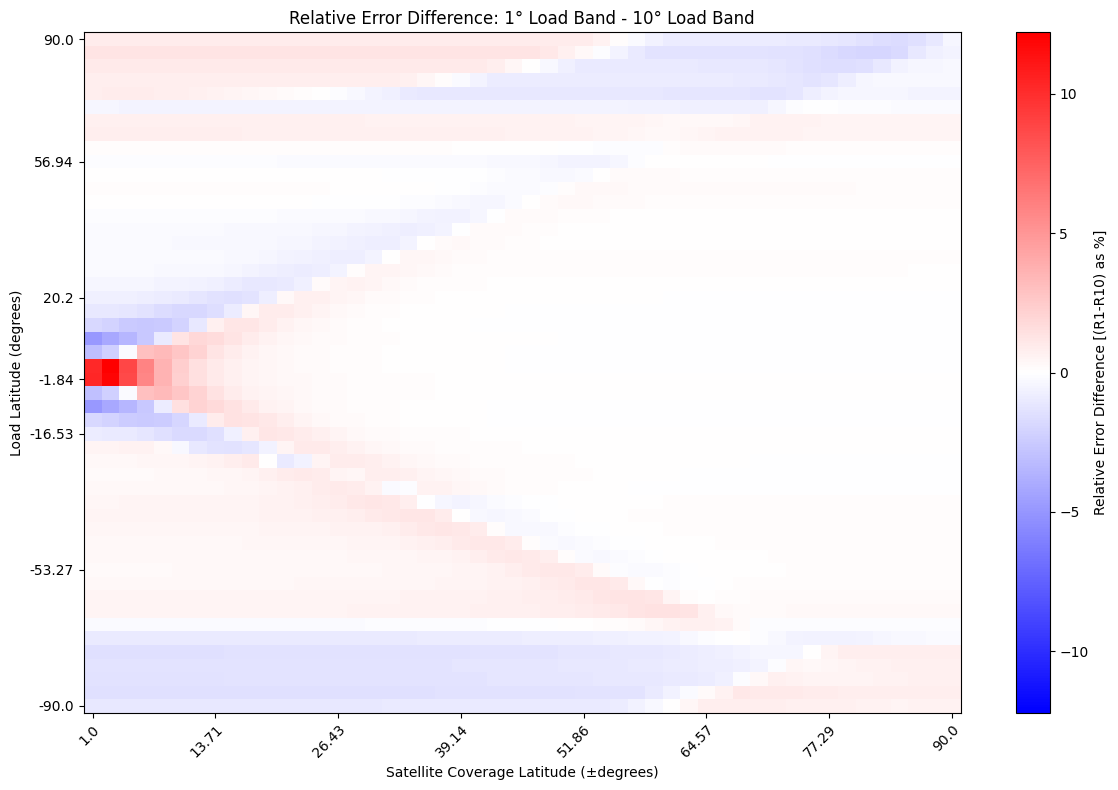

In [88]:
# plot of error for 1 degree error minus 10 degrees error

difference_data = error_output[error_output["load_radius"].isin([1, 10])]
difference_pivot = difference_data.pivot_table(
    index="latitude",
    columns=["satellite_range", "load_radius"],
    values="error",
)

# Extract error grids for load_radius 1 and 10 across all satellite ranges
err_r1 = difference_pivot.xs(1, level="load_radius", axis=1)
err_r10 = difference_pivot.xs(10, level="load_radius", axis=1)
difference = err_r1 - err_r10

fig, ax = plt.subplots(figsize=(12, 8))
vmax = np.nanmax(np.abs(difference.values))
im = ax.imshow(
    difference,
    aspect="auto",
    origin="lower",
    cmap="bwr",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar(im, ax=ax, label="Relative Error Difference [(R1-R10) as %]")
ax.set_xlabel("Satellite Coverage Latitude (±degrees)")
ax.set_ylabel("Load Latitude (degrees)")
ax.set_title("Relative Error Difference: 1° Load Band - 10° Load Band")

# Show all ticks and label them with the respective list entries
max_ticks = 7

# X-axis ticks (satellite range)
if len(satellite_range) <= max_ticks + 1:
    x_tick_indices = list(range(len(satellite_range)))
else:
    step = len(satellite_range) // max_ticks
    x_tick_indices = list(range(0, len(satellite_range), step))
    if x_tick_indices[-1] != len(satellite_range) - 1:
        x_tick_indices.append(len(satellite_range) - 1)

# Y-axis ticks (latitude)
if len(latitude) <= max_ticks:
    y_tick_indices = list(range(len(latitude)))
else:
    middle_idx = np.argmin(np.abs(latitude))
    step = len(latitude) // (max_ticks - 2)
    y_tick_indices = list(range(0, len(latitude), step))
    if middle_idx not in y_tick_indices:
        y_tick_indices.append(middle_idx)
    if y_tick_indices[-1] != len(latitude) - 1:
        y_tick_indices.append(len(latitude) - 1)
    y_tick_indices = sorted(set(y_tick_indices))

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(
    [satellite_range[i] for i in x_tick_indices],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_yticks(y_tick_indices)
ax.set_yticklabels([latitude[i] for i in y_tick_indices])

plt.tight_layout()
plt.show()


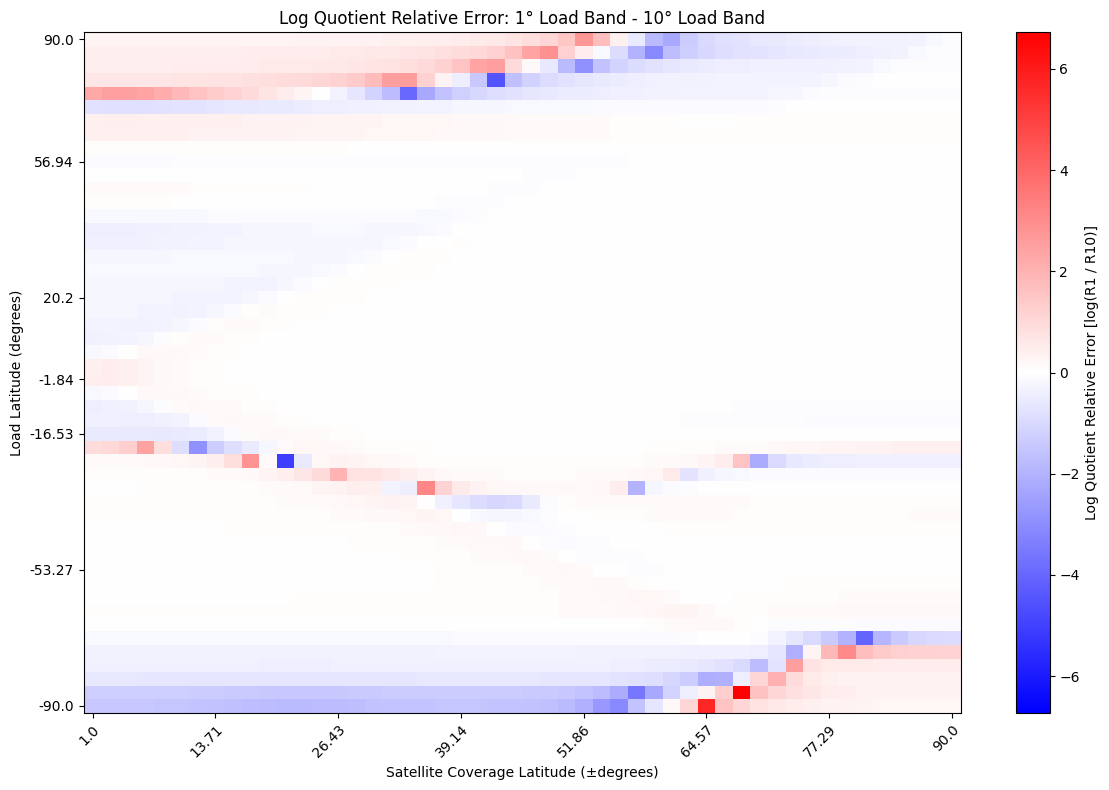

In [89]:
# plot of error for 1 degree error minus 10 degrees error

difference_data = error_output[error_output["load_radius"].isin([1, 10])]
difference_pivot = difference_data.pivot_table(
    index="latitude",
    columns=["satellite_range", "load_radius"],
    values="error",
)

# Extract error grids for load_radius 1 and 10 across all satellite ranges
err_r1 = difference_pivot.xs(1, level="load_radius", axis=1)
err_r10 = difference_pivot.xs(10, level="load_radius", axis=1)
quotient = err_r1 / err_r10
log_quotient = np.log(quotient)

fig, ax = plt.subplots(figsize=(12, 8))
vmax = np.nanmax(np.abs(log_quotient.values))
im = ax.imshow(
    log_quotient,
    aspect="auto",
    origin="lower",
    cmap="bwr",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar(im, ax=ax, label="Log Quotient Relative Error [log(R1 / R10)]")
ax.set_xlabel("Satellite Coverage Latitude (±degrees)")
ax.set_ylabel("Load Latitude (degrees)")
ax.set_title("Log Quotient Relative Error: 1° Load Band - 10° Load Band")

# Show all ticks and label them with the respective list entries
max_ticks = 7

# X-axis ticks (satellite range)
if len(satellite_range) <= max_ticks + 1:
    x_tick_indices = list(range(len(satellite_range)))
else:
    step = len(satellite_range) // max_ticks
    x_tick_indices = list(range(0, len(satellite_range), step))
    if x_tick_indices[-1] != len(satellite_range) - 1:
        x_tick_indices.append(len(satellite_range) - 1)

# Y-axis ticks (latitude)
if len(latitude) <= max_ticks:
    y_tick_indices = list(range(len(latitude)))
else:
    middle_idx = np.argmin(np.abs(latitude))
    step = len(latitude) // (max_ticks - 2)
    y_tick_indices = list(range(0, len(latitude), step))
    if middle_idx not in y_tick_indices:
        y_tick_indices.append(middle_idx)
    if y_tick_indices[-1] != len(latitude) - 1:
        y_tick_indices.append(len(latitude) - 1)
    y_tick_indices = sorted(set(y_tick_indices))

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(
    [satellite_range[i] for i in x_tick_indices],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_yticks(y_tick_indices)
ax.set_yticklabels([latitude[i] for i in y_tick_indices])
plt.tight_layout()
plt.show()
